Group assignment: Second-level analysis
===

# 0. Setup

## Imports

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
from nipype import config
import os
from os.path import join as opj, abspath
import numpy as np
import pandas as pd
from nilearn import datasets, plotting, image
from pprint import pprint
from glob import glob


config.update_config(
    {
        "logging": {"workflow_level": "INFO"},
        "execution": {
            "stop_on_first_crash": "True",
            "hash_method": "content",
            "remove_unnecessary_outputs": "True",
        },
    }
)


# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]



'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI


In [82]:
chosen_contrast = "observation > navigation"


contrast_dir_dict = {
    "navigation > baseline * cumulative distance error (vm)": "navigation",
    "obervation > baseline * cumulative distance error (vm)": "other",
    "observation > navigation": "other-self",
    "?": "self",
    "navigation > observation": "self-other",
}

data_dir = (
    "data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

## Download data

In [83]:
print(f"data is stored in: {abspath(data_dir)}")

data is stored in: /main/assignments/Group assignment/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/other-self-AllSessions


In [84]:
cmaps = sorted(
    glob(
        f"{abspath(data_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]


There are 59 contrast maps


# Second-level analysis

## Basic model for `other > self`

In [85]:
# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix.head()

,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


In [101]:
from nilearn.glm.second_level import SecondLevelModel

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

other_self = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="z_score"
)

# remove negative values
other_self.dataobj[other_self.dataobj < 0] = 0

`threshold=3`

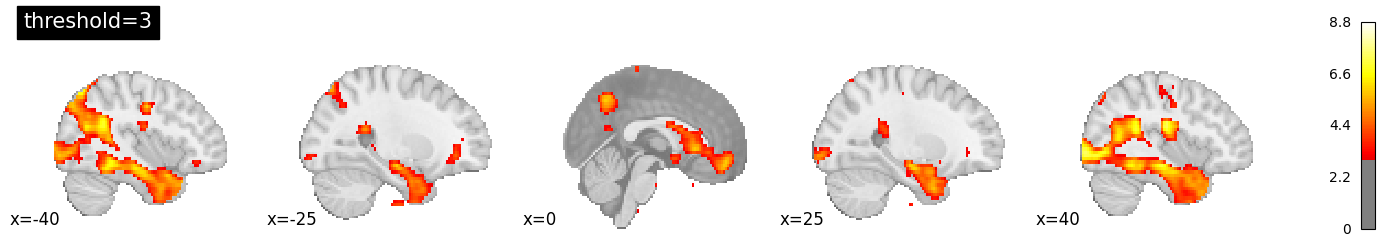

In [102]:
thresh = 3
disp_3 = plotting.plot_stat_map(
    other_self,
    threshold=thresh,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    title=f"threshold={thresh}",
    draw_cross=False,
)

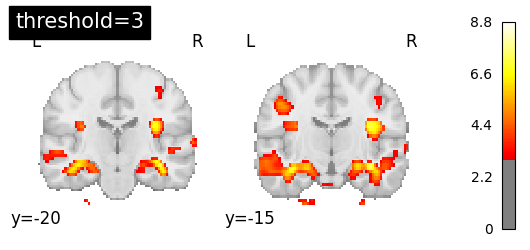

In [103]:
thresh = 3
disp_3 = plotting.plot_stat_map(
    other_self,
    threshold=thresh,
    cut_coords=(-20, -15),
    display_mode="y",
    title=f"threshold={thresh}",
    draw_cross=False,
)

## Correcting multiple comparisons

<div class="alert alert-warning">Do we need the complete image with all the negative activations for calculating the threshold?</div>

In [147]:
from nilearn.glm import threshold_stats_img

thresholded_map, threshold = threshold_stats_img(
    other_self, alpha=0.001, height_control="fdr", cluster_threshold=80, two_sided=False
)

print(f"The FDR=.05 threshold is {round(threshold, 3)}")

The FDR=.05 threshold is 3.441


### Thresholded z map, expected fdr = .05, clusters = 10"

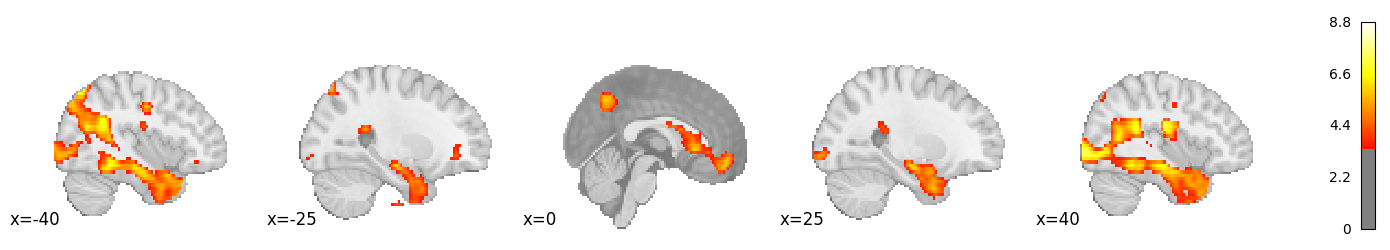

In [148]:
plotting.plot_stat_map(
    thresholded_map,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
)

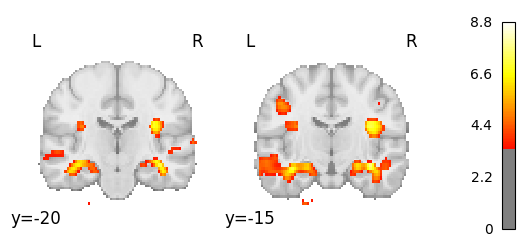

In [149]:
plotting.plot_stat_map(
    thresholded_map,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
)

## Surface plots

In [150]:
from nilearn import surface
from nilearn import datasets

fsaverage = datasets.fetch_surf_fsaverage()
texture_right = surface.vol_to_surf(thresholded_map, fsaverage.pial_right)
texture_left = surface.vol_to_surf(thresholded_map, fsaverage.pial_left)

### Right hemisphere

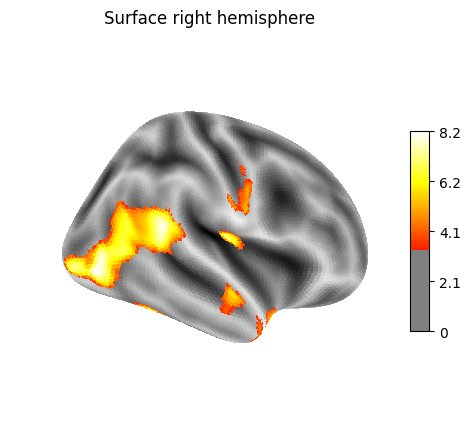

In [151]:
fig = plotting.plot_surf_stat_map(
    fsaverage.infl_right,
    texture_right,
    hemi="right",
    title="Surface right hemisphere",
    colorbar=True,
    threshold=threshold,
    bg_map=fsaverage.sulc_right,
)
fig.show()

### Left hemisphere

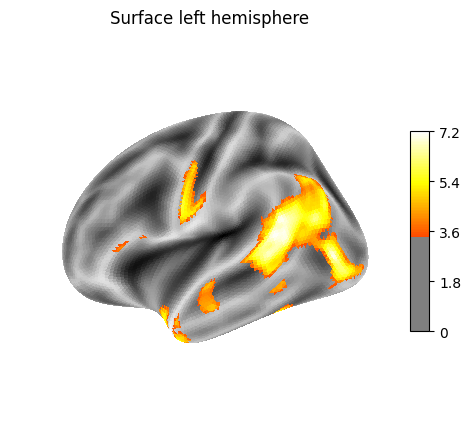

In [152]:
fig = plotting.plot_surf_stat_map(
    fsaverage.infl_left,
    texture_left,
    hemi="left",
    title="Surface left hemisphere",
    colorbar=True,
    threshold=threshold,
    bg_map=fsaverage.sulc_left,
)
fig.show()

### Higher resolution

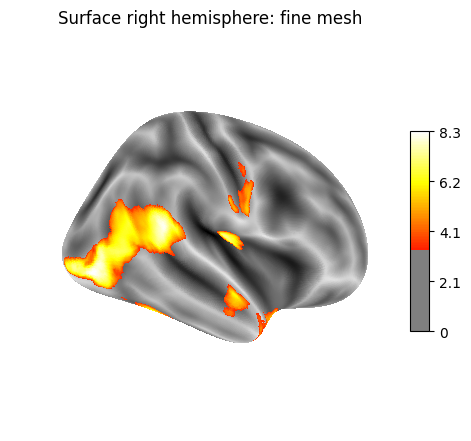

In [153]:
big_fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
big_texture = surface.vol_to_surf(thresholded_map, big_fsaverage.pial_right)

plotting.plot_surf_stat_map(
    big_fsaverage.infl_right,
    big_texture,
    hemi="right",
    colorbar=True,
    title="Surface right hemisphere: fine mesh",
    threshold=threshold,
    bg_map=big_fsaverage.sulc_right,
)
plotting.show()

### Multiple views

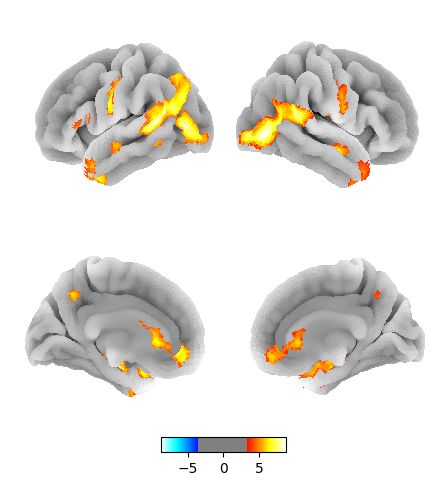

In [154]:
plotting.plot_img_on_surf(
    thresholded_map,
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    threshold=threshold,
    colorbar=True,
)
plotting.show()

# 2. Store objects

Save

In [117]:
import pickle

pickle.dump(second_level, open("second_level.pkl", "wb"))
!ls ./

'Group assignment.ipynb'   data   data_Wagner_NatComms_2022   second_level.pkl


Load

In [118]:
secondlvl_pkl = pickle.load(open("second_level.pkl", "rb"))

secondlvl_pkl.design_matrix_.head()

,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


As we have pickled the already fitted object, we can go ahead and evaluate some contrasts (without fitting the model again):

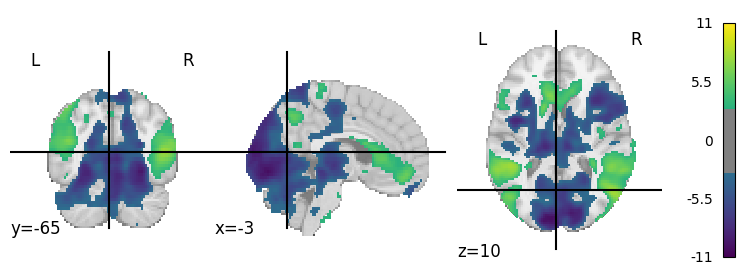

In [119]:
other_self_pkl = secondlvl_pkl.compute_contrast(
    second_level_contrast="intercept", output_type="z_score"
)

plotting.plot_stat_map(other_self_pkl, threshold=3, cmap="viridis")